In [16]:
import matplotlib
import matplotlib.pylab as plt
import glob
import numpy
import math
from joblib import Parallel, delayed

# Configuration
RUN_ID = "1"
RUNNING_TIME = 20

In [17]:
def res_dir(rid):
    return "results/" + rid

In [18]:
def process_log(filename):
    print("Processing", filename)

    publications = {}
    latencies = {}
    max_time = 0
    sync_pack = 0
    sync_byte = 0
    
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith('SYNC_'):
                val = int(line.split('=')[1])
                if line.startswith('SYNC_PACK'):
                    sync_pack = val
                if line.startswith('SYNC_BYTE'):
                    sync_byte = val
                    
                continue
            
            line = [x.strip() for x in line.split(',')]
            
            time = float(line[0])
            node = line[1]
            mtype = line[2]
            mid = line[3]
            
            if mtype == 'PUB':
                publications[mid] = time
            
            if mtype == 'RECV':
                if mid not in latencies:
                    latencies[mid] = []
                latencies[mid].append(time - publications[mid])
                
            max_time = max(max_time, time)
    
    return latencies, max_time, sync_pack, sync_byte

In [55]:
#new log format
# method = 'FULL'
# grid = '4'
# loss = '0'
# topology = '6node'
# logfiles = glob.glob("exp_log_files_josh/" +
#                          method + "_Method-" +
#                          topology + '-' +
#                          "1000_MS_INTER_SLOW-100_MS_INTER_FAST-"+
#                          "*_Nodes_Pub_Fast-"+
#                          "*_RECENT_PUB-" +
#                          "*_RANDOM_PUB-10_S_STOP-" +
#                          loss + "_DROP_RATE*.log")
logfiles = ['exp_log_files_seiji/simple.txt']
print(logfiles)
testOut = process_log(logfiles[0])

logHandler = open("processed_log.txt", "w")
# logHandler.write(str(testOut))

['exp_log_files_seiji/simple.txt']
Processing exp_log_files_seiji/simple.txt


In [50]:
def average_delay_for_node(node, log_file):
    publications = {}
    latencies = []
    max_time = 0

    time_this_node_started = None
    with open(log_file, 'r') as f:
        for line in f:
            if line.startswith('SYNC_'):
                val = int(line.split('=')[1])
                if line.startswith('SYNC_PACK'):
                    sync_pack = val
                if line.startswith('SYNC_BYTE'):
                    sync_byte = val
                continue
            line = [x.strip() for x in line.split(',')]

            time = float(line[0])
            curr_node = line[1]
            mtype = line[2]
            mid = line[3]
            if mtype == 'PUB':
                if time_this_node_started is None and curr_node == node:
                    time_this_node_started = time
                publications[mid] = time
            if node != curr_node:
                continue
            if mtype == 'RECV':
                latencies.append(time - max(publications[mid], time_this_node_started))
            max_time = max(max_time, time)
        print(f"Average delay (ms) for node {node}: {sum(latencies)/len(latencies)}")

In [42]:
def get_participants():
    participants = set()
    with open(log_file, 'r') as f:
        for line in f:
            if line.startswith('SYNC_'):
                continue
            participants.add(line.split(',')[1])
    
    return participants

In [51]:
log_file = logfiles[0]
print("Processing", log_file)
for participant in get_participants():
    average_delay_for_node(participant, log_file)
#note: we delay start of node1 publishing by 3 seconds in simulation

Processing exp_log_files_seiji/simple.txt
Average delay (ms) for node /Bertrand: 13.53630864197449
Average delay (ms) for node /Alice: 13.535938271604117
Average delay (ms) for node /Coral: 13.5062682926821


In [52]:
def add_plot(result_dictionary, label, marker):
    lists = sorted(result_dictionary.items())
    x, y = zip(*lists)
    plt.plot(x, y, label=label, marker=marker)

In [58]:
results50 = {}
results90 = {}
results_pack = {}
results_byte = {}
marker = 'o'
label = 'foobar'
fig = matplotlib.pyplot.gcf()
def set_p(latency_dictionary, max_time, sync_pack, sync_byte):
    scale = math.sqrt(1) #original author does this
    # I'm assuming this is  to normalize values s.t they have a standard deviation of 1
    nums50 = []
    nums90 = []
    for messageID in latency_dictionary:
        print(f'messageID (key for latency dic) is {messageID}')
        nums50.append(numpy.percentile(latency_dictionary[messageID], 50))
        nums90.append(numpy.percentile(latency_dictionary[messageID], 90))

    print(f'Max time: {max_time}')
    total_pubs_per_sec = len(latency_dictionary)/(max_time/1000)
    print(f'k is {total_pubs_per_sec}')
    results50[total_pubs_per_sec] = numpy.average(nums50) / scale
    results90[total_pubs_per_sec] = numpy.average(nums90) / scale
    results_pack[total_pubs_per_sec] = sync_pack
    results_byte[total_pubs_per_sec] = sync_byte


   
    add_plot(results50, label, marker)
    # return results90, results50, label, results_pack, results_byte, marker

<Figure size 432x288 with 0 Axes>

messageID (key for latency dic) is /Alice::1
messageID (key for latency dic) is /Coral::1
messageID (key for latency dic) is /Bertrand::1
messageID (key for latency dic) is /Bertrand::2
messageID (key for latency dic) is /Coral::2
messageID (key for latency dic) is /Alice::2
messageID (key for latency dic) is /Coral::3
messageID (key for latency dic) is /Bertrand::3
messageID (key for latency dic) is /Alice::3
messageID (key for latency dic) is /Bertrand::4
messageID (key for latency dic) is /Alice::4
messageID (key for latency dic) is /Coral::4
messageID (key for latency dic) is /Bertrand::5
messageID (key for latency dic) is /Alice::5
messageID (key for latency dic) is /Coral::5
messageID (key for latency dic) is /Bertrand::6
messageID (key for latency dic) is /Alice::6
messageID (key for latency dic) is /Coral::6
messageID (key for latency dic) is /Bertrand::7
messageID (key for latency dic) is /Alice::7
messageID (key for latency dic) is /Coral::7
messageID (key for latency dic) is

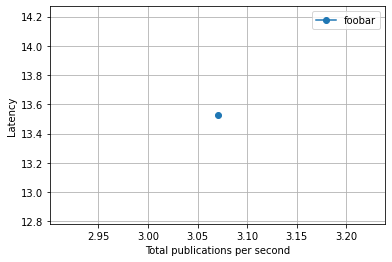

In [59]:
set_p(*testOut)
plt.xlabel("Total publications per second")
plt.ylabel("Latency")
fig.set_size_inches(6, 2.5)
plt.grid()
plt.legend()
fig.show()